In [7]:
import random
import numpy as np
import pandas as pd
import time
import re
import datetime
import os
import matplotlib.pyplot as plt
import gensim
import json

In [2]:
import nltk
from nltk.tokenize import sent_tokenize

In [3]:
df = pd.read_excel('data/Jul21_3379_articles.xlsx',index_col=0)
df = df.reset_index()
print(len(df))
df.head()

3379


,index,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category,textCharCt
0,0,apnews.com,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318
1,1,apnews.com,2021-10-12 07:00:00,https://apnews.com/cdfd9b277f6bade5697e0427429...,Blinken reaffirms US support for Ukraine amid ...,English,United States,"KYIV, Ukraine (AP) — U.S. Secretary of State A...",western,6032
2,2,apnews.com,2021-10-11 07:00:00,https://apnews.com/90b50e622cefcbaeba96cb5e716...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318
3,3,apnews.com,2021-10-06 07:00:00,https://apnews.com/0b689a7baaac58603e4d7453aa5...,Ukraine Holocaust center names Nazi Babi Yar k...,English,United States,"KYIV, Ukraine (AP) — The presidents of Ukraine...",western,3646
4,4,apnews.com,2021-10-13 07:00:00,https://apnews.com/89d2455274aad5fe166445a5f82...,Ukraine separatist areas overwhelmed by soarin...,English,United States,"KYIV, Ukraine (AP) — The Russia-backed separat...",western,2184


In [4]:
# df = df[df['newsOutlet'] != 'bbc.co.uk']/

In [5]:
# process texts
def tm_tokenize(txt):
    word_corrections = [
    ('said',''),
    ('Reuters',''),
    ('REUTERS',''),
    ('Thomson',''),
    ('AP', ''),
    ('Sputnik',''),
    ('TASS',''),
    ('BBC',''),
    ('Kiev ','Kyiv '),
    ('Lugansk','Luhansk'),
    ('Donbas','Donbass'),
    ('U.S.','US'),
    ('United States','US'),
    (''' We'd love to get your feedback at radio@sputniknews.com''',''),
    ('radio@sputniknews.com',''),
    ('Aleksandr', 'Alexander')
    ]
    takeoutif = [
        'This story has been corrected to show',
        'contributed to this report',
        'All rights reserved',
        'not responsible for the material quoted in these press',
        'Follow all AP stories',
        'https',
        'dedicated page',
        'Follow AP’s coverage',
        '©',
        'This video can not be played',
        '© 2022 Reuters.'
        'contributed reporting',
        'Please include your name, age and location with any submission.',
        'See here for',
        'contributed.',
        'reported from',
        'reaching billions of people worldwide every day',
        'quotes delayed a minimum',
        'contributed to this story.',
        'pic.twitter.com',
        'Screen for heightened risk individual and entities globally to help uncover hidden risks in business relationships and human networks.',
        'Browse an unrivalled portfolio of',
        'Access unmatched financial',
        'Reuters',
        'Build the strongest argument relying on',
        'The most comprehensive solution to manage all',
        'Access unmatched financial data',
        'The industry leader for online information for tax'
        ]
    for a, b in word_corrections:
        txt = txt.replace(a, b)
    for string in takeoutif:
        if string in txt:
            return None
    if not txt[0].isalpha() and txt[0] not in ['"',"'",'“']:
        return None
    if len(txt) <= 50:
        return None
    return txt

In [6]:
docs = []
texts = []

article2sents = dict()

listBySent = []
records = df.to_dict('records')
totalSents = 0
validSents = 0
for i, rec in enumerate(records):
    if i % 500 == 0:
        print(f'{i}/{len(records)} articles processed')
    rec_text = rec['text']
    if isinstance(rec_text, str):
        sents = sent_tokenize(rec_text)
        validSentsinDoc = []
        sentIdx = 0
    
        for text in sents:
            sentRec = dict()
            sentRec['index'] = i
            sentRec['newsOutlet'] = rec['newsOutlet']
            sentRec['category'] = rec['category']
            sentRec['dateSeen'] = rec['dateSeen']
            sentRec['url'] = rec['url']
            sentRec['title'] = rec['title']
            sentRec['language'] = rec['language']
            sentRec['sourceCountry'] = rec['sourceCountry']
            
            cleaned_text = tm_tokenize(text)
            totalSents += 1
            if cleaned_text == None:
                continue
            else:
                docs.append(cleaned_text)
                texts.append(text)
                sentRec['sentText'] = cleaned_text
                sentRec['sentIndexInText'] = sentIdx
                sentRec['articleIndex'] = i
                listBySent.append(sentRec)
                validSentsinDoc.append(text)
                validSents += 1
                sentIdx += 1
                
        article2sents[i] = validSentsinDoc
        
print(f'\n{validSents}/{totalSents} sentences valid.\n')
print(len(docs),'docs processed successfully!')

0/3379 articles processed
500/3379 articles processed
1000/3379 articles processed
1500/3379 articles processed
2000/3379 articles processed
2500/3379 articles processed
3000/3379 articles processed

55043/66347 sentences valid.

55043 docs processed successfully!


In [26]:
pwd

'/Users/paigelee/Desktop/summer2022/stanford/research/ukraine-media-CSLI'

In [27]:
%%time
sentenceDf = pd.read_excel('data/topic_model_data/fullSentDataFrame_8-1.xlsx',index_col=0)
sentenceDf.head()

CPU times: user 21.5 s, sys: 2.2 s, total: 23.7 s
Wall time: 29 s


,index,newsOutlet,category,dateSeen,url,title,language,sourceCountry,sentText,sentIndexInText,sentTopicID
225,11,apnews.com,western,2021-10-01 07:00:00,https://apnews.com/2c45904e7bea3b7d2705ddbdeee...,Georgia says its ex - president arrested after...,English,United States,The announcement by Prime Minister Irakli Gari...,1,-1
226,11,apnews.com,western,2021-10-01 07:00:00,https://apnews.com/2c45904e7bea3b7d2705ddbdeee...,Georgia says its ex - president arrested after...,English,United States,Details of the arrest were not immediately cle...,2,-1
233,11,apnews.com,western,2021-10-01 07:00:00,https://apnews.com/2c45904e7bea3b7d2705ddbdeee...,Georgia says its ex - president arrested after...,English,United States,It is unclear whether the EU deal will be foll...,9,-1
234,11,apnews.com,western,2021-10-01 07:00:00,https://apnews.com/2c45904e7bea3b7d2705ddbdeee...,Georgia says its ex - president arrested after...,English,United States,"In July, Georgian Dream withdrew from the agre...",10,-1
236,11,apnews.com,western,2021-10-01 07:00:00,https://apnews.com/2c45904e7bea3b7d2705ddbdeee...,Georgia says its ex - president arrested after...,English,United States,Saakashvili’s intense grin in police custody u...,12,-1


## N-gram analysis

In [28]:
import itertools
import stanza

In [31]:
stanza.download('en')
nlp = stanza.Pipeline('en')

2022-07-31 18:05:04 INFO: Downloading default packages for language: en (English)...
2022-07-31 18:05:06 INFO: File exists: /Users/paigelee/stanza_resources/en/default.zip.
2022-07-31 18:05:10 INFO: Finished downloading models and saved to /Users/paigelee/stanza_resources.


In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import state_union

engStopwords = set(stopwords.words('english'))

In [34]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/paigelee/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [ ]:
jsonDict = dict()

In [32]:
i = sentenceDf.iloc[100]['sentText']

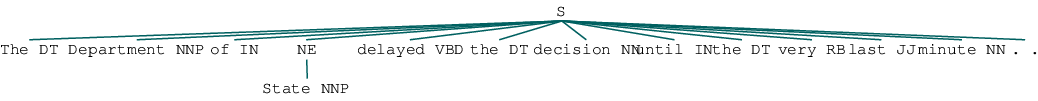

In [40]:
words = nltk.word_tokenize(i)
tagged = nltk.pos_tag(words)
namedEnt = nltk.ne_chunk(tagged, binary=True)
namedEnt

In [42]:
%%time
# get cooccurrence connections
thresh = 5
n = 4

allSentRecords = sentenceDf.to_dict('records')

for cat in ['western','russian']:
    networkJson = dict()
    networkJson['nodes'] = []
    networkJson['links'] = []

    curatedNodes = set()
    linkCounter = dict()
    keywordCounter = dict()

    windowList = []
    records = []
    for d in allSentRecords:
        if d['category'] == cat and d['sentTopicID'] != -1:
            records.append(d)
    for i, rec in enumerate(random.sample(records,100)):
        if i % 1000 == 0:
            print(f'{i}/{len(records)} recs parsed by NLP')
        docText = rec['sentText']
        nlpdoc = nlp(docText)
        wordList = [w for w in nlpdoc.iter_words() if w.text.isalpha() and w.text.lower() not in engStopwords]
        for windowIdx in range(len(wordList) // n + len(wordList) % n):
            startIdx = windowIdx
            endIdx = windowIdx+random.choice(list(range(1,n+1)))
            wordWindow = wordList[startIdx:endIdx]
            tokens = []
            for wordToken in wordWindow:
                formattedToken = wordToken.lemma.lower()
                if formattedToken in engStopwords:
                    continue
                tokens.append(formattedToken)
            windowList.append(tokens)
        for t1 in [w.lemma.lower() for w in wordList]:
            keywordCounter.setdefault(t1, 0)
            keywordCounter[t1] += 1
    print('\tdone nlping docs')
    sufficientNodes = set()
    for key in keywordCounter:
        if keywordCounter[key] >= thresh:
            sufficientNodes.add(key)
    print('\tfound sufficient recs')
    for tokens in windowList:
        s = set(tokens)
        subsets = [tuple(i) for i in itertools.combinations(s, 2)]
        for t1, t2 in subsets:
            if t1 != t2 and t1 in sufficientNodes and t2 in sufficientNodes:
                label = '_'.join(sorted([t1, t2]))
                linkCounter.setdefault(label, 0)
                linkCounter[label] += 1
    print('\tgot linked tokens')
    node2id = dict()
    for i, node in enumerate(sufficientNodes):
        networkJson['nodes'].append({
            'id' : node,
            'occurrences' : keywordCounter[node]
        })
        node2id[node] = i

    for label in linkCounter:
        source, target = label.split('_')
        networkJson['links'].append({
            'source' : node2id[source],
            'target' : node2id[target],
            'value' : linkCounter[label]
        })
    
    jsonDict[cat] = networkJson
    
    with open(f'data/{cat}ngramNet{n}.json', 'w', encoding ='ascii') as json_file:
        json.dump(networkJson, json_file, ensure_ascii = True)
    print('\twrote json')

0/18530 recs parsed by NLP
1000/18530 recs parsed by NLP
2000/18530 recs parsed by NLP
3000/18530 recs parsed by NLP
4000/18530 recs parsed by NLP
5000/18530 recs parsed by NLP
6000/18530 recs parsed by NLP
7000/18530 recs parsed by NLP
8000/18530 recs parsed by NLP
9000/18530 recs parsed by NLP
10000/18530 recs parsed by NLP
11000/18530 recs parsed by NLP
12000/18530 recs parsed by NLP
13000/18530 recs parsed by NLP
14000/18530 recs parsed by NLP
15000/18530 recs parsed by NLP
16000/18530 recs parsed by NLP
17000/18530 recs parsed by NLP
18000/18530 recs parsed by NLP
	done nlping docs
	found sufficient recs
	got linked tokens
	wrote json
0/22646 recs parsed by NLP
1000/22646 recs parsed by NLP
2000/22646 recs parsed by NLP
3000/22646 recs parsed by NLP
4000/22646 recs parsed by NLP
5000/22646 recs parsed by NLP
6000/22646 recs parsed by NLP
7000/22646 recs parsed by NLP
8000/22646 recs parsed by NLP
9000/22646 recs parsed by NLP
10000/22646 recs parsed by NLP
11000/22646 recs parsed 

In [38]:
# with open(f'data/russianngramNet.json', 'w', encoding ='ascii') as json_file:
#         json.dump(jsonDict['russian'], json_file, ensure_ascii = True)

### Running network analysis

In [3]:
with open(f'visualizations/ngramsNetwork/russianngramNet4.json', 'r', encoding ='ascii') as f:
    network = json.loads(f.read())

In [12]:
id2node = dict()
for i, n in enumerate(network['nodes']):
    id2node[i] = n['id']

In [15]:
len(network['links'])

107193

In [21]:
for i, l in enumerate(network['links']):
    s = l['source']
    t = l['target']
    v = l['value']
    if 'deny' in [id2node[s],id2node[t]] and v > 10:
        print([id2node[s],id2node[t]], l)

['deny', 'moscow'] {'source': 3203, 'target': 1084, 'value': 91}
['deny', 'repeatedly'] {'source': 3203, 'target': 2094, 'value': 136}
['deny', 'russia'] {'source': 3203, 'target': 454, 'value': 36}
['accusation', 'deny'] {'source': 1725, 'target': 3203, 'value': 104}
['deny', 'say'] {'source': 3203, 'target': 397, 'value': 19}
['claim', 'deny'] {'source': 4305, 'target': 3203, 'value': 31}
['allegation', 'deny'] {'source': 1587, 'target': 3203, 'value': 60}
['deny', 'plan'] {'source': 3203, 'target': 4532, 'value': 31}
['deny', 'invade'] {'source': 3203, 'target': 4233, 'value': 17}
['deny', 'point'] {'source': 3203, 'target': 1929, 'value': 31}
['deny', 'intention'] {'source': 3203, 'target': 2162, 'value': 20}


In [14]:
id2node[2219], id2node[2904]

('agreement', 'vladimir')

In [8]:
random.choice(network['nodes'])

{'id': 'intent', 'occurrences': 17}

In [9]:
random.choice(network['links'])

{'source': 2219, 'target': 2904, 'value': 2}